# Corona Cases Classification Using Ensemble Learning Classifiers 

## Import Required Libraries 

In [1]:
import pandas as panda
import seaborn as seaBorn 
import matplotlib.pyplot as plot
plot.style.use('default')

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

## Load Dataset and Dataset Overview

In [2]:
coronaDT = panda.read_csv("corona-dataset.csv", na_values=['None'])
coronaDT.head(5)

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed


In [3]:
coronaDT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               278848 non-null  int64 
 1   Test_date            278848 non-null  object
 2   Cough_symptoms       278596 non-null  object
 3   Fever                278596 non-null  object
 4   Sore_throat          278847 non-null  object
 5   Shortness_of_breath  278847 non-null  object
 6   Headache             278847 non-null  object
 7   Corona               278848 non-null  object
 8   Age_60_above         151528 non-null  object
 9   Sex                  259285 non-null  object
 10  Known_contact        278848 non-null  object
dtypes: int64(1), object(10)
memory usage: 23.4+ MB


In [4]:
coronaDT.isnull().sum()

Ind_ID                      0
Test_date                   0
Cough_symptoms            252
Fever                     252
Sore_throat                 1
Shortness_of_breath         1
Headache                    1
Corona                      0
Age_60_above           127320
Sex                     19563
Known_contact               0
dtype: int64

In [5]:
coronaDT.duplicated().sum()

0

## Data Cleaning

### 1. Handle Null Values

In [6]:
(coronaDT.isnull().sum()/coronaDT.shape[0]) * 100

Ind_ID                  0.000000
Test_date               0.000000
Cough_symptoms          0.090372
Fever                   0.090372
Sore_throat             0.000359
Shortness_of_breath     0.000359
Headache                0.000359
Corona                  0.000000
Age_60_above           45.659284
Sex                     7.015650
Known_contact           0.000000
dtype: float64

Here, we drop column age_60_above because it has more than 40% NA values, and for the sex column, we will use the imputer technique to fill the NA values and drop NA rows from other columns. 

In [7]:
coronaDTCleaned = coronaDT.drop(['Age_60_above', 'Ind_ID', 'Test_date'], axis = 1)
coronaDTCleaned['Sex'].fillna(coronaDTCleaned['Sex'].mode()[0], inplace = True)

coronaDTCleaned.dropna(subset = ['Cough_symptoms','Fever','Sore_throat',
                                 'Shortness_of_breath',
                                 'Headache'], axis = 0, inplace = True)

(coronaDTCleaned.isnull().sum()/coronaDTCleaned.shape[0]) * 100

Cough_symptoms         0.0
Fever                  0.0
Sore_throat            0.0
Shortness_of_breath    0.0
Headache               0.0
Corona                 0.0
Sex                    0.0
Known_contact          0.0
dtype: float64

In [8]:
coronaDTCleaned = coronaDTCleaned[coronaDTCleaned['Corona'].isin(['positive', 'negative'])]

## Exploratory Data Analysis (EDA)

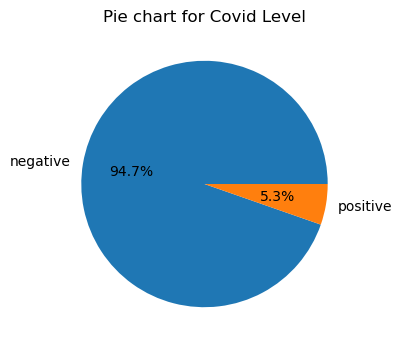

In [9]:
covidLevel = coronaDTCleaned['Corona'].value_counts()

plot.figure(figsize=(4,4))
plot.pie(covidLevel, labels = covidLevel.index, autopct='%1.1f%%')
plot.title('Pie chart for Covid Level')
plot.show()

## Data Preprocessing

### 4. Encode Categorial Variables

In [10]:
modelData = coronaDTCleaned.copy(deep = True)
modelData_Encoded = panda.get_dummies(modelData, columns=['Cough_symptoms', 'Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache', 'Sex', 'Known_contact'])
modelData_Encoded.head(5)

,Corona,Cough_symptoms_False,Cough_symptoms_True,Fever_False,Fever_True,Sore_throat_False,Sore_throat_True,Shortness_of_breath_False,Shortness_of_breath_True,Headache_False,Headache_True,Sex_female,Sex_male,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other
0,negative,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0
1,positive,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0
2,positive,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0
3,negative,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0
4,negative,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0


### 5. Extrat Features and Target

In [11]:
features = modelData_Encoded.drop('Corona', axis=1)
target   = modelData_Encoded['Corona']

### 7. SMOTE for class imbalance

In [35]:
# Employed Smote
smote = SMOTE()
featuresSmote, targetSmote = smote.fit_resample(features, target)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(featuresSmote, targetSmote, test_size = 0.2, random_state = 42)

print("Training Dataset size :", X_train.shape, y_train.shape)
print("Testing Dataset size :", X_test.shape, y_test.shape)

Training Dataset size : (416012, 15) (416012,)
Testing Dataset size : (104004, 15) (104004,)


## Machine Learning Model's 

### 1. Random Forest Classifier

In [32]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators      = 100,  
                                       criterion         ='gini',  
                                       max_depth         = 10,  
                                       min_samples_split = 2,  
                                       min_samples_leaf  = 1,  
                                       max_features      = 'auto',  
                                       random_state      = 42,
                                       n_jobs            = -1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='auto', n_jobs=-1,
                       random_state=42)

In [33]:
rfPredicTest = rf_classifier.predict(X_test)
rfPredicTrain = rf_classifier.predict(X_train)

#### Evaluation on Training Dataset

In [34]:
RF_accuracy_train  = accuracy_score(y_train, rfPredicTrain)
RF_recall_train    = recall_score(y_train, rfPredicTrain, average='micro')
RF_precision_train = precision_score(y_train, rfPredicTrain, average='micro')
RF_f1_Score_train  = f1_score(y_train, rfPredicTrain, average='micro')

print("Training Accuracy for Random Forest Model:", round(RF_accuracy_train, 4))
print("Training Recall for Random Forest Model:", round(RF_recall_train, 4))
print("Training Precision for Random Forest Model:", round(RF_precision_train, 4))
print("Training F1 Score for Random Forest Model:", round(RF_f1_Score_train, 4))

Training Accuracy for Random Forest Model: 0.8504
Training Recall for Random Forest Model: 0.8504
Training Precision for Random Forest Model: 0.8504
Training F1 Score for Random Forest Model: 0.8504


#### Evaluation on Testing Dataset

In [36]:
RF_accuracy_test  = accuracy_score(y_test, rfPredicTest)
RF_recall_test    = recall_score(y_test, rfPredicTest, average='micro')
RF_precision_test = precision_score(y_test, rfPredicTest, average='micro')
RF_f1_Score_test  = f1_score(y_test, rfPredicTest, average='micro')
RF_report_test    = classification_report(y_test, rfPredicTest)

print("Accuracy for Random Forest Model:", round(RF_accuracy_test, 3))
print("Recall for Random Forest Model:", round(RF_recall_test, 3))
print("Precision for Random Forest Model:", round(RF_precision_test, 3))
print("F1 Score for Random Forest Model:", round(RF_f1_Score_test, 3))
print("Classification Report for Random Forest Model \n\n", RF_report_test)

Accuracy for Random Forest Model: 0.85
Recall for Random Forest Model: 0.85
Precision for Random Forest Model: 0.85
F1 Score for Random Forest Model: 0.85
Classification Report for Random Forest Model 

               precision    recall  f1-score   support

    negative       0.81      0.91      0.86     51916
    positive       0.89      0.79      0.84     52088

    accuracy                           0.85    104004
   macro avg       0.85      0.85      0.85    104004
weighted avg       0.85      0.85      0.85    104004



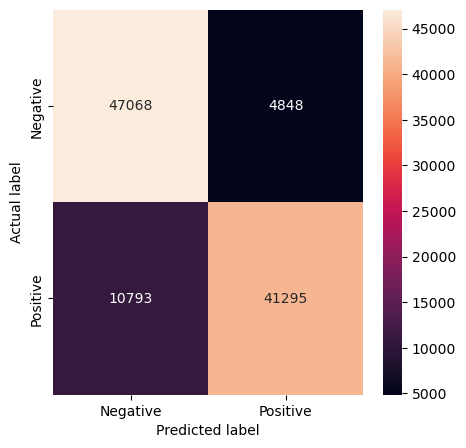

In [41]:
rf_confusionMatrix = panda.DataFrame(confusion_matrix(y_test, rfPredicTest), index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plot.figure(figsize=(5,5))
seaBorn.heatmap(rf_confusionMatrix, annot=True, fmt='g')
plot.ylabel('Actual label')
plot.xlabel('Predicted label')
plot.show()

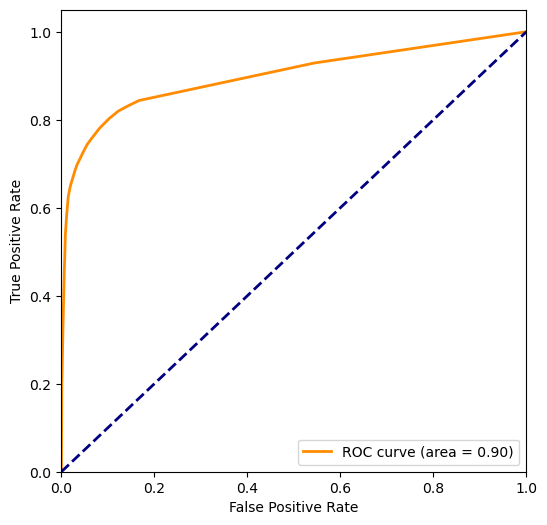

In [76]:
rfPredicTest_proba = rf_classifier.predict_proba(X_test)

rfPredicTest_positive_proba = rfPredicTest_proba[:, 1]
y_test_flat = y_test.replace({'positive': 1, 'negative': 0})
fpr, tpr, thresholds = roc_curve(y_test_flat, rfPredicTest_positive_proba)
roc_auc = auc(fpr, tpr)
plot.figure(figsize=(6,6))
plot.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.legend(loc="lower right")
plot.show()

### 2. Gradient Boosting Classifier

In [16]:
gbClassifier = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                      criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, max_depth=3, 
                                      max_features=None, random_state=None, warm_start=False, 
                                      validation_fraction=0.1, n_iter_no_change=None, tol=1e-4)
gbClassifier.fit(X_train, y_train)

GradientBoostingClassifier(loss='deviance')

In [17]:
gbPredicTest  = gbClassifier.predict(X_test)
gbPredicTrain = gbClassifier.predict(X_train)

#### Evaluation on Training Dataset

In [18]:
GB_accuracy_train  = accuracy_score(y_train, gbPredicTrain)
GB_recall_train    = recall_score(y_train, gbPredicTrain, average='micro')
GB_precision_train = precision_score(y_train, gbPredicTrain, average='micro')
GB_f1_Score_train  = f1_score(y_train, gbPredicTrain, average='micro')

print("Training Accuracy for Gradient Boosting Model:", round(GB_accuracy_train, 4))
print("Training Recall for Gradient Boosting Model:", round(GB_recall_train, 4))
print("Training Precision for Gradient Boosting Model:", round(GB_precision_train, 4))
print("Training F1 Score for Gradient Boosting Model:", round(GB_f1_Score_train, 4))

Training Accuracy for Gradient Boosting Model: 0.851
Training Recall for Gradient Boosting Model: 0.851
Training Precision for Gradient Boosting Model: 0.851
Training F1 Score for Gradient Boosting Model: 0.851


#### Evaluation on Testing Dataset

In [19]:
gb_accuracy_test  = accuracy_score(y_test, gbPredicTest)
gb_recall_test    = recall_score(y_test, gbPredicTest, average='micro')
gb_precision_test = precision_score(y_test, gbPredicTest, average='micro')
gb_f1_Score_test  = f1_score(y_test, gbPredicTest, average='micro')
gb_report   = classification_report(y_test, gbPredicTest)

print("Accuracy for Gradient Boosting Classifier:", round(gb_accuracy_test, 4))
print("Recall for Gradient Boosting Classifier:", round(gb_recall_test, 4))
print("Precision for Gradient Boosting Classifier:", round(gb_precision_test, 4))
print("F1 Score for Gradient Boosting Classifier:", round(gb_f1_Score_test, 4))
print("Classification Report for Gradient Boosting Classifier \n\n", gb_report)

Accuracy for Gradient Boosting Classifier: 0.8504
Recall for Gradient Boosting Classifier: 0.8504
Precision for Gradient Boosting Classifier: 0.8504
F1 Score for Gradient Boosting Classifier: 0.8504
Classification Report for Gradient Boosting Classifier 

               precision    recall  f1-score   support

    negative       0.81      0.91      0.86     51916
    positive       0.90      0.79      0.84     52088

    accuracy                           0.85    104004
   macro avg       0.85      0.85      0.85    104004
weighted avg       0.85      0.85      0.85    104004



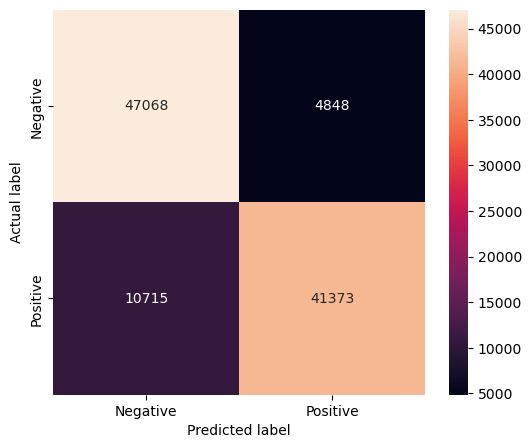

In [36]:
gb_confusionMatrix = panda.DataFrame(confusion_matrix(y_test, gbPredicTest), index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plot.figure(figsize=(6,5))
seaBorn.heatmap(gb_confusionMatrix, annot=True, fmt='g')
plot.ylabel('Actual label')
plot.xlabel('Predicted label')
plot.show()

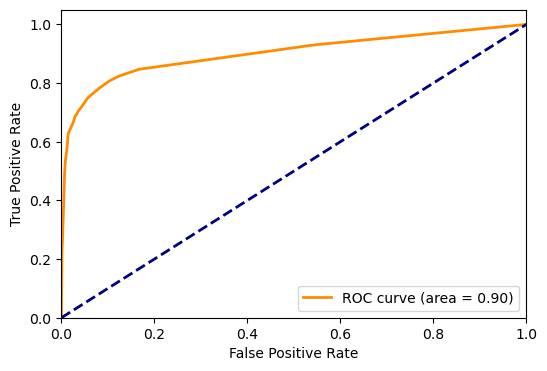

In [38]:
gbPredicTest_proba = gbClassifier.predict_proba(X_test)

gbPredicTest_positive_proba = gbPredicTest_proba[:, 1]
y_test_flat = y_test.replace({'positive': 1, 'negative': 0})
fpr, tpr, thresholds = roc_curve(y_test_flat, gbPredicTest_positive_proba)
roc_auc = auc(fpr, tpr)
plot.figure(figsize=(6,4))
plot.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.legend(loc="lower right")
plot.show()

## Artificial Neural Network 

In [25]:
# Encode the categorical target variable
label_encoder  = LabelEncoder()
target_encoder = label_encoder.fit_transform(target)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_encoder, test_size=0.2, random_state=42)

print("Training Dataset size :", X_train.shape, y_train.shape)
print("Testing Dataset size :", X_test.shape, y_test.shape)

Training Dataset size : (219761, 15) (219761,)
Testing Dataset size : (54941, 15) (54941,)


In [26]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [27]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
    
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
    
model.add(Dense(1, activation='sigmoid'))  
    
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 10, 
                               restore_best_weights = True)

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs     = 50, 
                    batch_size = 64,
                    callbacks  = [early_stopping], 
                    verbose    = 1)

Epoch 1/50
3434/3434 [==============================] - 9s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9451 - val_loss: 0.0000e+00 - val_accuracy: 0.9468
Epoch 2/50
3434/3434 [==============================] - 8s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9464 - val_loss: 0.0000e+00 - val_accuracy: 0.9468
Epoch 3/50
3434/3434 [==============================] - 8s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9464 - val_loss: 0.0000e+00 - val_accuracy: 0.9468
Epoch 4/50
3434/3434 [==============================] - 8s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9464 - val_loss: 0.0000e+00 - val_accuracy: 0.9468
Epoch 5/50
3434/3434 [==============================] - 7s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9464 - val_loss: 0.0000e+00 - val_accuracy: 0.9468
Epoch 6/50
3434/3434 [==============================] - 8s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9464 - val_loss: 0.0000e+00 - val_accuracy: 0.9468
Epoch 7/50
3434/3434 [==============================] - 10s 3ms/step - loss: 0.0000e+00 

In [29]:
annPredicTest  = model.predict(X_test)
annPredicTrain = model.predict(X_train)

6868/6868 [==============================] - 7s 1ms/step


#### Evaluation on Training Dataset

In [30]:
ANN_accuracy_train  = accuracy_score(y_train, annPredicTrain)
ANN_recall_train    = recall_score(y_train, annPredicTrain, average='micro')
ANN_precision_train = precision_score(y_train, annPredicTrain, average='micro')
ANN_f1_Score_train  = f1_score(y_train, annPredicTrain, average='micro')

print("Training Accuracy for Artificial Neutral Network Model:", round(ANN_accuracy_train, 4))
print("Training Recall for Artificial Neutral Network Model:", round(ANN_recall_train, 4))
print("Training Precision for Artificial Neutral Network Model:", round(ANN_precision_train, 4))
print("Training F1 Score for Artificial Neutral Network Model:", round(ANN_f1_Score_train, 4))

Training Accuracy for Artificial Neutral Network Model: 0.9464
Training Recall for Artificial Neutral Network Model: 0.9464
Training Precision for Artificial Neutral Network Model: 0.9464
Training F1 Score for Artificial Neutral Network Model: 0.9464


#### Evaluation on Testing Dataset

In [31]:
ANN_accuracy_test  = accuracy_score(y_test, annPredicTest)
ANN_recall_test    = recall_score(y_test, annPredicTest, average='micro')
ANN_precision_test = precision_score(y_test, annPredicTest, average='micro')
ANN_f1_Score_test  = f1_score(y_test, annPredicTest, average='micro')
ANN_report         = classification_report(y_test, annPredicTest)

print("Accuracy for Artificial Neutral Network Model:", round(ANN_accuracy_test, 4))
print("Recall for Artificial Neutral Network Model:", round(ANN_recall_test, 4))
print("Precision for Artificial Neutral Network Model:", round(ANN_precision_test, 4))
print("F1 Score for Artificial Neutral Network Model:", round(ANN_f1_Score_test, 4))
print("Classification Report for Artificial Neutral Network Model \n\n", ANN_report)

Accuracy for Artificial Neutral Network Model: 0.9468
Recall for Artificial Neutral Network Model: 0.9468
Precision for Artificial Neutral Network Model: 0.9468
F1 Score for Artificial Neutral Network Model: 0.9468
Classification Report for Artificial Neutral Network Model 

               precision    recall  f1-score   support

           0       0.95      1.00      0.97     52020
           1       0.00      0.00      0.00      2921

    accuracy                           0.95     54941
   macro avg       0.47      0.50      0.49     54941
weighted avg       0.90      0.95      0.92     54941

